In [1]:
import torch
import importlib
import yaml

### Data

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import glob
import librosa
import numpy as np
import xml.etree.ElementTree as ET

class MiviaDataset(torch.utils.data.Dataset):
    def __init__(self, mivia_path, max_frames = 60, fs = 16000, partition = ['A'], hop_length = 128, net_pooling = 1):
        self.mivia_path = mivia_path
        self.max_frames = max_frames
        self.partition = partition
        self.fs = fs

        xml_list = []
        for partition in self.partition:
            xml_list += glob.glob(f"{self.mivia_path}/audio/{partition}/*.xml")

        self.xml_files = xml_list

        ## for label encoding
        n_samples = self.max_frames * self.fs
        self.hop_length = hop_length
        self.net_pooling = net_pooling
        self.n_frames = int(int((n_samples/ self.hop_length)) / self.net_pooling)


    def _time_to_frame(self, time):
        samples = time * self.fs
        frame = (samples) / self.hop_length
        return np.clip(frame / self.net_pooling, a_min=0, a_max=self.n_frames)
    
    def _encoder_strong_label(self, xml_dir):
        """Encode a list of strong label"""
        xml = ET.parse(xml_dir)
        root = xml.getroot()

        item = root.find("events").findall("item")

        onset = [float(x.findtext("STARTSECOND")) for x in item] # list, str
        offset = [float(x.findtext("ENDSECOND")) for x in item]  # list, str
        label_idx = [int(x.findtext("CLASS_ID")) for x in item] 

        target = np.zeros([self.n_frames, 2], dtype = 'float32')  # shape : [frame, class], class : 3

        if (len(onset) != len(offset)): 
            print("wrong")
        else:
            for i in range(len(onset)):
                start = int(self._time_to_frame(onset[i])) #버림 -> 해당 time frame에 걸쳐있으면 true??
                if offset[i] > self.max_frames:
                    offset[i] = self.max_frames
                end = int(np.ceil(self._time_to_frame(offset[i])))   #올림 -> 해당 time frame에 걸쳐있으면 true
                target[start:end, (label_idx[i]-2)] = 1 # (class_id[i]-1) = 1 : scream, 2 : tire skidding, 3 : car crash
        return (target)
    
    def __len__(self):
        return len(self.xml_files)
    
  
    def __getitem__(self, idx):
        target = self._encoder_strong_label(self.xml_files[idx])
        partition = self.xml_files[idx].split('/')[-2]
        audio_path = self.xml_files[idx].replace('.xml', '_1.wav').replace(f'/{partition}/', f'/{partition}/v2/')
        audio_data, _ = librosa.load(audio_path, mono = True, sr = self.fs)

        # Padding if audio_data's length is less than self.max_frames*self.fs
        if len(audio_data) < self.max_frames * self.fs:
            padding = np.zeros((self.max_frames * self.fs) - len(audio_data))
            audio_data = np.concatenate((audio_data, padding))
            audio_data = audio_data.astype(np.float32)

        elif len(audio_data) > self.max_frames * self.fs:
            audio_data = audio_data[:self.max_frames * self.fs]
        
        return audio_data, target.transpose(1, 0)

    
import matplotlib.pyplot as plt

def draw_heatmap(data, sampling_frequency, hop_length):
    plt.figure(figsize=(10, 6)) # Figure size can be adjusted according to your preference
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar()  # Optional: if you want a colorbar to indicate the values
    
    x_ticks = np.arange(0, data.shape[1], step=5*sampling_frequency/hop_length)
    plt.xticks(x_ticks, x_ticks * (hop_length / sampling_frequency))
    plt.xlabel("Time (s)")
    
    plt.yticks([0, 1], ['tire', 'crash'])
    plt.show()




In [3]:
mivia_path ='./data/mivia_raw'
max_frames = 60
fs = 16000
partition = ['D']
hop_length = 128
net_pooling = 1
Test_DATASET = MiviaDataset(mivia_path, max_frames, fs, partition, hop_length, net_pooling)

In [4]:
data, label = Test_DATASET[1]
label.shape

(2, 7500)

In [8]:
def draw_heatmap(data, sampling_frequency, hop_length):
    plt.figure(figsize=(10, 6)) # Figure size can be adjusted according to your preference
    plt.imshow(data, aspect='auto', interpolation='nearest', cmap='viridis')
    plt.colorbar()  # Optional: if you want a colorbar to indicate the values
    
    x_ticks = np.arange(0, data.shape[1], step=5*sampling_frequency/hop_length)
    plt.xticks(x_ticks, x_ticks * (hop_length / sampling_frequency))
    plt.xlabel("Time (s)", fontsize = 20)
    
    plt.yticks([0, 1], ['tire', 'crash'], fontsize = 20)
    plt.show()

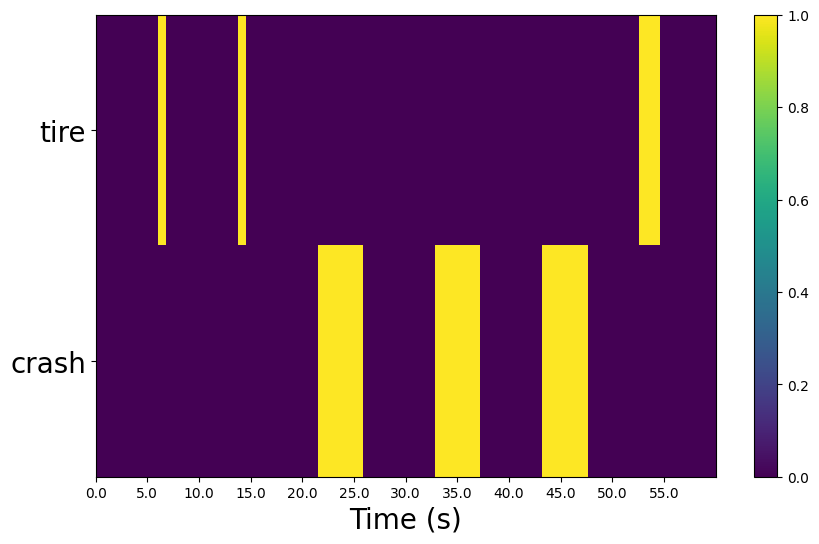

In [9]:
draw_heatmap(label, fs, hop_length)

### Teacher Model

In [10]:
with open('./configs/mivia_server_test.yaml', "r") as f:
    config_teacher = yaml.safe_load(f)

In [11]:
preprocess = importlib.import_module('models.' + config_teacher['feature_extractor']).__getattribute__("feature_extractor")
preprocess =  preprocess(**config_teacher['feature_extractor_config'])

model = importlib.import_module('models.' + config_teacher['model']).__getattribute__("MainModel")
model =  model(**config_teacher['model_config'])

/home/hhj/anaconda3/envs/speaker/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [12]:
from engine import FeatureExtractor as FeatureExtractor_teacher

feature_extractor_teacher = FeatureExtractor_teacher.load_from_checkpoint(preprocess = preprocess,model = model, checkpoint_path = config_teacher['resume_checkpoint'])
feature_extractor_teacher.eval()

Mel_Spectrogram(
  (mel_spectrogram): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)
CRNN(
  (cnn): CNN(
    (cnn): Sequential(
      (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm0): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (cg0): ContextGating(
        (sigmoid): Sigmoid()
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout0): Dropout(p=0.5, inplace=False)
      (pooling0): AvgPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0)
      (conv1): Dynamic_conv2d(
        (attention): attention2d(
          (conv1d1): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=same, bias=False)
          (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv1d2): Conv1d(8, 1, kernel_size=(1,), stride=(1,), padding=same)
        )
      )
      (batchnor

/home/hhj/anaconda3/envs/speaker/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'preprocess' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['preprocess'])`.
  rank_zero_warn(


FeatureExtractor(
  (preprocess): Mel_Spectrogram(
    (mel_spectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (model): CRNN(
    (cnn): CNN(
      (cnn): Sequential(
        (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (batchnorm0): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (cg0): ContextGating(
          (sigmoid): Sigmoid()
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (dropout0): Dropout(p=0.5, inplace=False)
        (pooling0): AvgPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0)
        (conv1): Dynamic_conv2d(
          (attention): attention2d(
            (conv1d1): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=same, bias=False)
            (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv1d2): Conv

In [13]:
mel = feature_extractor_teacher.preprocess(torch.from_numpy(data).unsqueeze(0))
y_hat_teacher, _ = feature_extractor_teacher.model(mel)

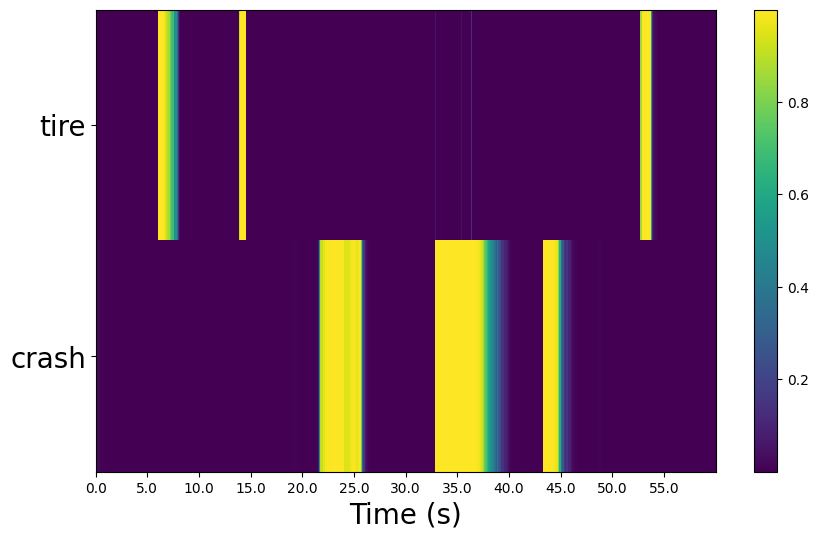

In [14]:
draw_heatmap(y_hat_teacher.detach().numpy()[0,:,:7500], fs, hop_length)

### Student Model

In [15]:
with open('./configs/mivia_baseline_test.yaml', "r") as f:
    config_student = yaml.safe_load(f)

In [16]:
preprocess = importlib.import_module('models.' + config_student['feature_extractor']).__getattribute__("feature_extractor")
preprocess =  preprocess(**config_student['feature_extractor_config'])

model = importlib.import_module('models.' + config_student['model']).__getattribute__("MainModel")
model =  model(**config_student['model_config'])

/home/hhj/anaconda3/envs/speaker/lib/python3.11/site-packages/torchaudio/functional/functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (257) may be set too low.
  warnings.warn(


In [17]:
from engine import FeatureExtractor as FeatureExtractor_student

feature_extractor_student = FeatureExtractor_student.load_from_checkpoint(preprocess = preprocess,model = model, checkpoint_path = config_student['resume_checkpoint'])
feature_extractor_student.eval()

Mel_Spectrogram(
  (mel_spectrogram): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)
CRNN(
  (cnn): CNN(
    (cnn1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
    )
    (cnn2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    )
    (cnn3): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
    )
  )
  (rnn): BidirectionalGRU(
    (rnn): GRU(384, 16, num_layers=2, batch_first=True, bidirectional=True)
  )
  (dropout): Dropout(p=0.5, inplace=False)
  (dense): Linear(in_features=32, out_features=2,

FeatureExtractor(
  (preprocess): Mel_Spectrogram(
    (mel_spectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (model): CRNN(
    (cnn): CNN(
      (cnn1): Sequential(
        (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 5), stride=(1, 5), padding=0, dilation=1, ceil_mode=False)
      )
      (cnn2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      )
      (cnn3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): ReLU()
        (2): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
      )
    )
    (rnn): BidirectionalGRU(
      (rnn): GRU(384, 16, num_layers=2, batch_first=True, bidirectional=True)
   

In [18]:
mel = feature_extractor_student.preprocess(torch.from_numpy(data).unsqueeze(0))
y_hat_student, _ = feature_extractor_student.model(mel)

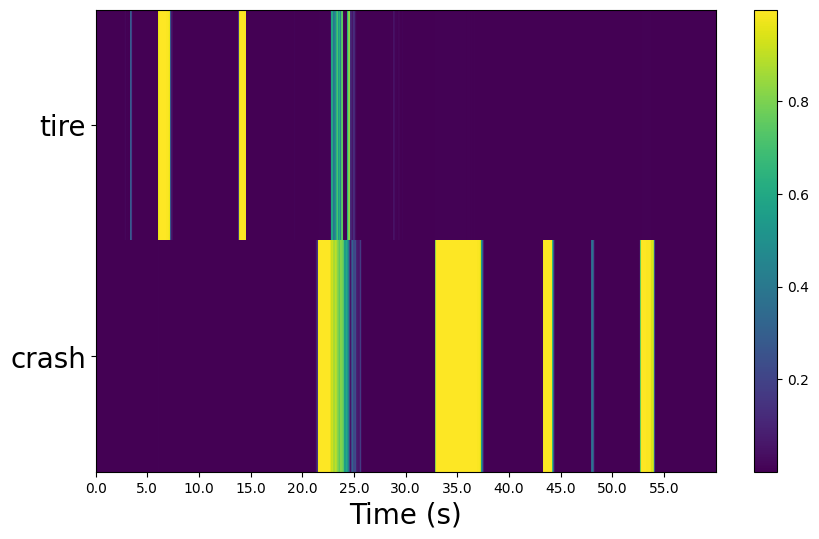

In [19]:
draw_heatmap(y_hat_student.detach().numpy()[0,:,:7500], fs, hop_length)

### Student Model(@KD)

In [21]:
with open('./configs/mivia_kd_test.yaml', "r") as f:
    config_kd = yaml.safe_load(f)

In [22]:
preprocess = importlib.import_module('models.' + config_kd['feature_extractor']).__getattribute__("feature_extractor")
preprocess =  preprocess(**config_kd['feature_extractor_config'])

model_student = importlib.import_module('models.' + config_kd['model_student']).__getattribute__("MainModel")
model_student =  model_student(**config_kd['model_student_config'])

In [23]:
from engine_kd import FeatureExtractor as FeatureExtractor_kd

feature_extractor_kd = FeatureExtractor_kd.load_from_checkpoint(preprocess = preprocess,model = model_student, checkpoint_path = config_kd['resume_checkpoint'])
feature_extractor_kd.eval()

Mel_Spectrogram(
  (mel_spectrogram): MelSpectrogram(
    (spectrogram): Spectrogram()
    (mel_scale): MelScale()
  )
)
CRNN(
  (cnn): CNN(
    (cnn): Sequential(
      (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (batchnorm0): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
      (cg0): ContextGating(
        (sigmoid): Sigmoid()
        (linear): Linear(in_features=32, out_features=32, bias=True)
      )
      (dropout0): Dropout(p=0.5, inplace=False)
      (pooling0): AvgPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0)
      (conv1): Dynamic_conv2d(
        (attention): attention2d(
          (conv1d1): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=same, bias=False)
          (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv1d2): Conv1d(8, 1, kernel_size=(1,), stride=(1,), padding=same)
        )
      )
      (batchnor

/home/hhj/anaconda3/envs/speaker/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model_teacher' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_teacher'])`.
  rank_zero_warn(
/home/hhj/anaconda3/envs/speaker/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:263: UserWarning: Attribute 'model_student' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model_student'])`.
  rank_zero_warn(


FeatureExtractor(
  (preprocess): Mel_Spectrogram(
    (mel_spectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (model_teacher): CRNN(
    (cnn): CNN(
      (cnn): Sequential(
        (conv0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (batchnorm0): BatchNorm2d(32, eps=0.001, momentum=0.99, affine=True, track_running_stats=True)
        (cg0): ContextGating(
          (sigmoid): Sigmoid()
          (linear): Linear(in_features=32, out_features=32, bias=True)
        )
        (dropout0): Dropout(p=0.5, inplace=False)
        (pooling0): AvgPool2d(kernel_size=[1, 2], stride=[1, 2], padding=0)
        (conv1): Dynamic_conv2d(
          (attention): attention2d(
            (conv1d1): Conv1d(32, 8, kernel_size=(3,), stride=(1,), padding=same, bias=False)
            (bn): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu): ReLU(inplace=True)
            (conv1d

In [24]:
mel = feature_extractor_kd.preprocess(torch.from_numpy(data).unsqueeze(0))
y_hat_kd, _ = feature_extractor_kd.model_student(mel)

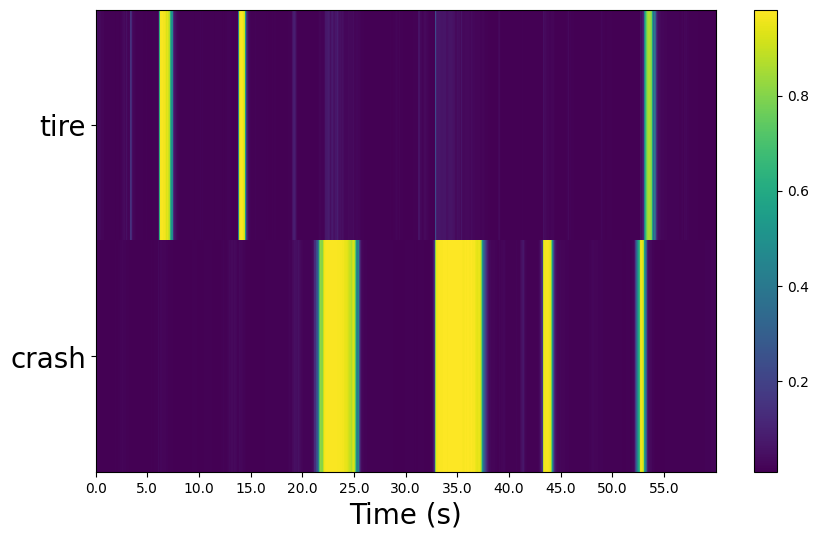

In [25]:
draw_heatmap(y_hat_kd.detach().numpy()[0,:,:7500], fs, hop_length)

In [21]:
y_hat_kd.shape

torch.Size([1, 2, 7501])